In [475]:
import pandas as pd
import numpy as np
import matplotlib as plt
import seaborn as sns
import sklearn
%matplotlib inline

### Now Lets explore the cleaned dataset !

In [476]:
df = pd.read_csv('DataALL_Cleaned.csv')

In [477]:
df1 = df.loc[df.SalePrice.isnull() == False ] #Seperating the training set from test

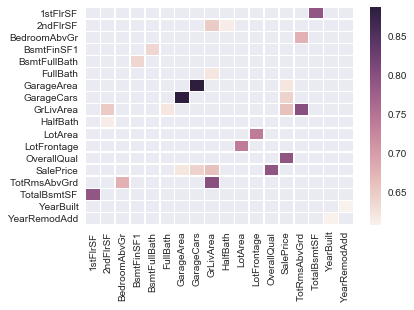

In [478]:
cols = list(df.corr()[(df.corr() >= 0.6) & (df.corr() != 1)].sum().where(lambda x: x != 0).dropna().index)
sns.heatmap(df.corr()[(df.corr() >= 0.6) & (df.corr() != 1)].loc[cols,cols],linewidths=.5)

As we can see from the above, there are some features that are highly correlated.

| Variable1 | Variable2 | Explaination |
| :------ | :------ | :------ |
| GarageArea| CarageCars | The larger the Garage Size, the more cars it can fit |
| 1stFlrSF| TotalBsmtSF | The way buildings are built, if the first floor is large, the basement will also be large |
| GrLivArea| TotalRmsAbvGrd | More rooms above ground = Larger Ground Living Area |
| SalePrice| OverallQual | This is interesting - SalePrice is highly correlated to Quality of the house |

For modelling purposes, we can remove some of these variables that are highly correlated.
It is however good to explore and understand some of these relationships to ensure that the correlations make sense - We cannot just blindly remove variables as there may be some interactions with other variables that may be valuable for our model to learn from


In [479]:
# Dropping the highly correlated variables
df.drop(['GarageCars','TotalBsmtSF','TotRmsAbvGrd'],axis=1,inplace=True)

### Categorical Variable Encoding

We have to encode the categorical variables to enable us to use them in our models. There are various ways of doing this depending on the number of unqiue values in each category and the type of categorical variable

Note that the curse of dimensionality can be an issue here so we would want to avoid that

### Ordinal Categorical Variables

In [480]:
# Lets start with the ordinal variables
import re

Ordinal_variables = ['ExterQual','ExterCond','BsmtCond','GarageCond', 'GarageQual', 'KitchenQual','HeatingQC']

#Replace No Values
for variables in Ordinal_variables:
    df[variables].replace(['No Basement','No Garage'],'No',inplace=True)

#Replacing categories with ordered integers
keys = {'Ex':5,'Gd':4, 'TA':3 , 'Fa':2, 'Po':1,'No':0}

#Encoding ordinal variables
for variables in Ordinal_variables:
    df[variables].replace(keys,inplace=True)
    
#Printing output
for variables in Ordinal_variables:
    print(variables,df[variables].unique())

ExterQual [4 3 5 2]
ExterCond [3 4 2 1 5]
BsmtCond [3 4 0 2 1 5]
GarageCond [3 0 4 2 1 5]
GarageQual [3 2 4 0 1 5]
KitchenQual [4 3 5 2]
HeatingQC [5 4 3 2 1]


In [481]:
#Lets look at the correlations between the encoded variables
#We can see that there is a high correlation between some features and we can remove them
df[Ordinal_variables].corr()[df[Ordinal_variables].corr()>0.5]

#Dropping highly correlated features
df.drop(['GarageCond','KitchenQual'],axis=1,inplace=True)

### Categorical Encoding - One-hot encoding

In [482]:
#Checking the number of unique values per categorical variable
# Therefore if small number then we can do one hot encoding
cat_cols = list(df.columns[df.dtypes == 'O'])
cat_nbr = [(cat_cols[i],len(df[cat_cols[i]].unique())) for i in range(len(cat_cols))]

#One hot encoding for all categories with less than or equal to 5
one_hot = [cat_nbr[i][0] for i in range(len(cat_nbr)) if cat_nbr[i][1] <=6]
print(one_hot)
#Performing one-hot encoding, with the drop_first setting = True
df = pd.get_dummies(df, columns = one_hot, prefix = one_hot,drop_first=True)


['BldgType', 'BsmtExposure', 'BsmtQual', 'CentralAir', 'Electrical', 'FireplaceQu', 'Foundation', 'GarageFinish', 'Heating', 'LandContour', 'LandSlope', 'LotConfig', 'LotShape', 'MSZoning', 'MasVnrType', 'PavedDrive', 'RoofStyle', 'SaleCondition', 'Street', 'Utilities']


In [483]:
large_cat = [cat_nbr[i][0] for i in range(len(cat_nbr)) if cat_nbr[i][1] >6]
for cols in large_cat:
    print(cols,len(df[cols].unique()))

BsmtFinType1 7
BsmtFinType2 7
Condition1 9
Condition2 8
Exterior1st 15
Exterior2nd 16
Functional 7
GarageType 7
HouseStyle 8
Neighborhood 25
RoofMatl 8
SaleType 9


### Encoding only Top N Categories

To prevent our dataset from a large increase in dimension, we take the catergorical variables where the number of categories are greater than 6. We therefore only one-hot encode the top-N categories

Therefore the remainder is classified where all dummy categories is equal to 0 for that variable. This helps us to limit the number of dimensions that our dataset expands by

In [484]:
# Function for creating variables for top X % categories
def Encode_TopCat(df,columns, threshold):
    Series = ((df[columns].value_counts().sort_values(ascending=False)/len(df)).cumsum())
    Cats = list(Series[Series<=threshold].index)
    for cat in Cats:
        df[columns + '_' + cat] = np.where(df[columns] == cat,1,0)
    df.drop(columns,axis=1,inplace=True)
    


In [485]:
#Encoding categories making up 95% of the observations only (top 95% categories)
for items in large_cat:
    if items != 'Neighborhood':
        Encode_TopCat(df,items,0.95)

In [486]:
cat_cols = list(df.columns[df.dtypes == 'O'])
cat_cols

['Neighborhood']

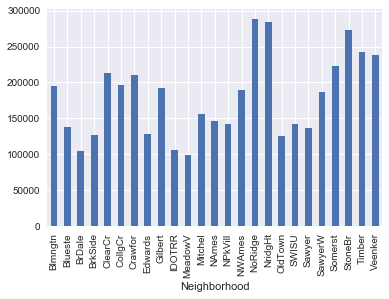

In [487]:
df.groupby(['Neighborhood']).SalePrice.mean().plot.bar()


### Mean Encoding

A seen in the above, it is clear that the Neighborhood has different prices. This is as expected and we probably can apply mean encoding to the neighborhood, instead of creating additional 24 variables.

In [488]:
#Mean housing prices per Neighborhood
Neighborhood_Prices = df.groupby(['Neighborhood']).SalePrice.mean().to_dict()

#Replacing values
df['Neighborhood'].replace(Neighborhood_Prices,inplace=True)

['2ndFlrSF',
 'GarageQual',
 'GarageYrBlt',
 'BsmtExposure_No Basement',
 'BsmtQual_No Basement',
 'SaleCondition_Partial',
 'BsmtFinType2_No Basement',
 'Exterior1st_VinylSd',
 'Exterior1st_MetalSd',
 'Exterior1st_HdBoard',
 'Exterior1st_Wd Sdng',
 'Exterior1st_CemntBd',
 'Exterior2nd_VinylSd',
 'Exterior2nd_MetalSd',
 'Exterior2nd_HdBoard',
 'Exterior2nd_Wd Sdng',
 'Exterior2nd_CmentBd',
 'HouseStyle_2Story',
 'SaleType_New']

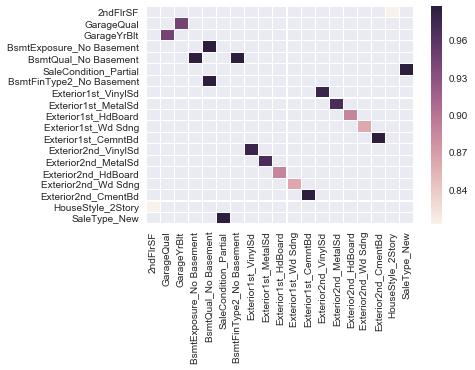

In [489]:
cols = list(df.corr()[(df.corr() >= 0.8) & (df.corr() != 1)].sum().where(lambda x: x != 0).dropna().index)
sns.heatmap(df.corr()[(df.corr() >= 0.8) & (df.corr() != 1)].loc[cols,cols],linewidths=.10)
cols

In [490]:
# There are a number of highly correlated features, we can therefore remove these
# Where correlation is at or above 0.8

drop_cols = ['GarageYrBlt','BsmtExposure_No Basement','SaleCondition_Partial','Exterior2nd_VinylSd','Exterior2nd_MetalSd',
            'Exterior2nd_HdBoard','Exterior2nd_Wd Sdng','Exterior2nd_CmentBd','HouseStyle_2Story','BsmtFinType2_No Basement']
df.drop(drop_cols,axis=1,inplace=True)

## Feature Importance - Feature Selection

In [491]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [537]:
def normalize(df):
    result = df.copy()
    for feature_name in df.columns:
        mean = df[feature_name].mean()
        std = df[feature_name].std()
        result[feature_name] = (df[feature_name] - mean) / (std)
    return result

In [541]:
#Test Train Split

#Normalize the Data
df1 = df.loc[df.SalePrice.isnull() == False]
df1 = normalize(df1)

y = df1.SalePrice
X = df1.drop(['Id' , 'SalePrice'], axis = 1)


X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=.5)

clf = RandomForestRegressor(n_jobs=10, n_estimators=1000)
model = clf.fit(X_train, y_train)
importance= sorted(zip(X_train.columns,model.feature_importances_))



In [542]:
Feature_Importance = (dict(zip(X_train.columns,model.feature_importances_)))
df3 = pd.Series(Feature_Importance)

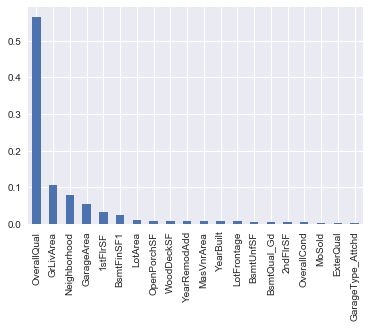

In [543]:
df3.sort_values(ascending=False).head(20).plot.bar()